# **Import necessary libraries and packages**

In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import os
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support



import torch
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Using CPU")


2024-08-05 04:42:42.842824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 04:42:42.842943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 04:42:42.983214: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using GPU: Tesla T4


In [5]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10)
model.to(device)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# **Download necessary NLTK data files**

In [6]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
import nltk

# Specify the directory where you want to download NLTK data
nltk.data.path.append('/kaggle/working/')

# Download required NLTK data
nltk.download('stopwords', download_dir='/kaggle/working/')
nltk.download('punkt', download_dir='/kaggle/working/')
nltk.download('wordnet', download_dir='/kaggle/working/')

[nltk_data] Downloading package stopwords to /kaggle/working/...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /kaggle/working/...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /kaggle/working/...


True

# **1. Data Loading**

In [8]:
data_path = '/kaggle/input/genre-classification-data'
files = os.listdir(data_path)
print(files)

file_name = 'wiki_movie_plots_deduped.csv'  
file_path = os.path.join(data_path, file_name)
data = pd.read_csv(file_path)


['wiki_movie_plots_deduped.csv']


In [9]:
print(f"Shape of the dataset: {data.shape}")

Shape of the dataset: (34886, 8)


### According to the result, there are 34,886 rows and 8 columns in the dataset. This indicates that there are 34,886 distinct entries, or records, with eight characteristics or attributes for each. These elements might comprise columns with movie titles, synopses, genres, and possibly additional metadata about the films. This huge dataset size offers a significant amount of data for identifying patterns and producing precise predictions, which is advantageous for building strong machine learning models. 

In [10]:
genre_mapping = {
    "action": "action",
    "action & romance": "action-romance",
    "action / adventure": "action-adventure",
    "action / adventure / martial arts": "action-adventure",
    "action / comedy": "action-comedy",
    "action / crime": "action-crime",
    "action / crime / drama": "action-crime-drama",
    "action / crime / thriller": "action-crime-thriller",
    "action / drama": "action-drama",
    "action / fantasy": "action-fantasy",
    "action / kung fu / comedy": "action-kung fu-comedy",
    "action / martial arts": "action-martial arts",
    "action / martial arts / comedy": "action-martial arts-comedy",
    "action / romance": "action-romance",
    "action / thriller": "action-thriller",
    "action adventure": "action-adventure",
    "action comedy": "action-comedy",
    "action drama": "action-drama",
    "action masala": "action-masala",
    "action romance": "action-romance",
    "action thriller": "action-thriller",
    "action, adventure": "action-adventure",
    "action, comedy": "action-comedy",
    "action, comedy, crime, drama": "action-comedy-crime-drama",
    "action, comedy, drama": "action-comedy-drama",
    "action, comedy, romance": "action-comedy-romance",
    "action, crime": "action-crime",
    "action, crime drama": "action-crime-drama",
    "action, crime, drama": "action-crime-drama",
    "action, crime, drama, romance": "action-crime-drama-romance",
    "action, crime, drama, thriller": "action-crime-drama-thriller",
    "action, crime, romance": "action-crime-romance",
    "action, drama": "action-drama",
    "action, drama, family": "action-drama-family",
    "action, drama, romance": "action-drama-romance",
    "action, family": "action-family",
    "action, fantasy": "action-fantasy",
    "action, horror": "action-horror",
    "action, masala": "action-masala",
    "action, romance": "action-romance",
    "action, romance, drama": "action-romance-drama",
    "action, sci-fi": "action-sci-fi",
    "action, science fiction": "action-sci-fi",
    "action, spy film": "action-spy",
    "action, thriller": "action-thriller",
    "action, war": "action-war",
    "action-adventure": "action-adventure",
    "action-adventure, fantasy": "action-adventure-fantasy",
    "action-comedy": "action-comedy",
    "action-masala": "action-masala",
    "action-thriller": "action-thriller",
    "action/adventure": "action-adventure",
    "action/comedy": "action-comedy",
    "action/drama": "action-drama",
    "action/romance": "action-romance",
    "action/romance/comedy": "action-romance-comedy",
    "action/thriller": "action-thriller",
    "adult": "adult",
    "adult comedy": "adult-comedy",
    "adult film": "adult-film",
    "adventure": "adventure",
    "adventure drama": "adventure-drama",
    "adventure serial": "adventure-serial",
    "adventure, comedy": "adventure-comedy",
    "adventure, drama": "adventure-drama",
    "adventure, family": "adventure-family",
    "adventure, fantasy": "adventure-fantasy",
    "african adventure": "adventure",
    "animated": "animated",
    "animated comedy": "animated-comedy",
    "animated feature": "animated-feature",
    "animated film": "animated-film",
    "animated short": "animated-short",
    "animated, comedy": "animated-comedy",
    "animated, comedy, family": "animated-comedy-family",
    "animated, family": "animated-family",
    "animation": "animation",
    "animation adventure": "animation-adventure",
    "animation comedy": "animation-comedy",
    "animation, comedy": "animation-comedy",
    "animation, family": "animation-family",
    "anime": "anime",
    "anime fantasy": "anime-fantasy",
    "anime for children": "anime-children",
    "anthology": "anthology",
    "anthology, horror": "anthology-horror",
    "biblical": "biblical",
    "biblical drama": "biblical-drama",
    "biker film": "biker-film",
    "bio-pic": "biopic",
    "bio-pic, drama": "biopic-drama",
    "biographical": "biographical",
    "biographical drama": "biographical-drama",
    "biographical, drama": "biographical-drama",
    "biography": "biography",
    "biography, crime": "biography-crime",
    "biography, drama": "biography-drama",
    "biography, musical": "biography-musical",
    "biography, sports": "biography-sports",
    "biography, war": "biography-war",
    "biopic": "biopic",
    "biopic, drama": "biopic-drama",
    "black comedy": "black-comedy",
    "children": "children",
    "children's film": "children",
    "christian": "christian",
    "comedy": "comedy",
    "comedy / action": "comedy-action",
    "comedy / drama": "comedy-drama",
    "comedy / fantasy": "comedy-fantasy",
    "comedy / horror": "comedy-horror",
    "comedy / romance": "comedy-romance",
    "comedy drama": "comedy-drama",
    "comedy film": "comedy",
    "comedy horror": "comedy-horror",
    "comedy mystery": "comedy-mystery",
    "comedy romance": "comedy-romance",
    "comedy short": "comedy-short",
    "comedy thriller": "comedy-thriller",
    "comedy western": "comedy-western",
    "comedy, action": "comedy-action",
    "comedy, adventure": "comedy-adventure",
    "comedy, biography": "comedy-biography",
    "comedy, crime": "comedy-crime",
    "comedy, drama": "comedy-drama",
    "comedy, drama, family": "comedy-drama-family",
    "comedy, drama, musical": "comedy-drama-musical",
    "comedy, drama, romance": "comedy-drama-romance",
    "comedy, family": "comedy-family",
    "comedy, fantasy": "comedy-fantasy",
    "comedy, horror": "comedy-horror",
    "comedy, musical": "comedy-musical",
    "comedy, mystery": "comedy-mystery",
    "comedy, parody": "comedy-parody",
    "comedy, romance": "comedy-romance",
    "comedy, romance, musical": "comedy-romance-musical",
    "comedy, satire": "comedy-satire",
    "comedy, science fiction": "comedy-sci-fi",
    "comedy, sports": "comedy-sports",
    "comedy, teen": "comedy-teen",
    "comedy, thriller": "comedy-thriller",
    "comedy, western": "comedy-western",
    "comedy-drama": "comedy-drama",
    "comedy-drama, romance": "comedy-drama-romance",
    "comedy-thriller": "comedy-thriller",
    "comedy/action": "comedy-action",
    "comedy/crime": "comedy-crime",
    "comedy/drama": "comedy-drama",
    "comedy/horror": "comedy-horror",
    "comedy/musical": "comedy-musical",
    "comedy/romance": "comedy-romance",
    "comedy/satire": "comedy-satire",
    "comedy/thriller": "comedy-thriller",
    "coming-of-age drama": "coming-of-age",
    "costume": "costume",
    "costume action": "costume-action",
    "costume drama": "costume-drama",
    "crime": "crime",
    "crime / drama": "crime-drama",
    "crime / thriller": "crime-thriller",
    "crime comedy": "crime-comedy",
    "crime drama": "crime-drama",
    "crime thriller": "crime-thriller",
    "crime, action": "crime-action",
    "crime, comedy": "crime-comedy",
    "crime, drama": "crime-drama",
    "crime, drama, mystery": "crime-drama-mystery",
    "crime, drama, thriller": "crime-drama-thriller",
    "crime, horror": "crime-horror",
    "crime, thriller": "crime-thriller",
    "crime/drama": "crime-drama",
    "crime/romance": "crime-romance",
    "crime/thriller": "crime-thriller",
    "dance": "dance",
    "dance, drama": "dance-drama",
    "dark comedy": "dark-comedy",
    "detective": "detective",
    "devotional": "devotional",
    "disaster": "disaster",
    "disaster film": "disaster",
    "docudrama": "docudrama",
    "documentary": "documentary",
    "drama": "drama",
    "drama / action": "drama-action",
    "drama / action / crime": "drama-action-crime",
    "drama / comedy": "drama-comedy",
    "drama / comedy / romance": "drama-comedy-romance",
    "drama / crime": "drama-crime",
    "drama / family": "drama-family",
    "drama / mystery / crime": "drama-mystery-crime",
    "drama / romance": "drama-romance",
    "drama / thriller": "drama-thriller",
    "drama film": "drama",
    "drama romance": "drama-romance",
    "drama, action": "drama-action",
    "drama, adventure": "drama-adventure",
    "drama, biography": "drama-biography",
    "drama, comedy": "drama-comedy",
    "drama, crime": "drama-crime",
    "drama, epic": "drama-epic",
    "drama, family": "drama-family",
    "drama, fantasy": "drama-fantasy",
    "drama, horror": "drama-horror",
    "drama, music": "drama-music",
    "drama, musical": "drama-musical",
    "drama, mystery": "drama-mystery",
    "drama, romance": "drama-romance",
    "drama, romance, slice of life": "drama-romance",
    "drama, romance, thriller": "drama-romance-thriller",
    "drama, romantic comedy": "drama-romantic-comedy",
    "drama, science fiction": "drama-sci-fi",
    "drama, social": "drama-social",
    "drama, sports": "drama-sports",
    "drama, thriller": "drama-thriller",
    "drama, war": "drama-war",
    "drama, western": "drama-western",
    "drama-thriller": "drama-thriller",
    "drama/action": "drama-action",
    "drama/biographical": "drama-biographical",
    "drama/comedy": "drama-comedy",
    "drama/history": "drama-history",
    "drama/musical": "drama-musical",
    "drama/romance": "drama-romance",
    "drama/thriller": "drama-thriller",
    "dramatic comedy": "dramatic-comedy",
    "dramedy": "dramedy",
    "educational": "educational",
    "epic": "epic",
    "ero": "ero",
    "erotic / drama": "erotic-drama",
    "erotic thriller": "erotic-thriller",
    "espionage": "espionage",
    "experimental": "experimental",
    "exploitation": "exploitation",
    "family": "family",
    "family comedy": "family-comedy",
    "family drama": "family-drama",
    "family film": "family-film",
    "family, comedy": "family-comedy",
    "family, drama": "family-drama",
    "family, fantasy": "family-fantasy",
    "family, live-action": "family-live-action",
    "family, musical": "family-musical",
    "fantasy": "fantasy",
    "fantasy adventure": "fantasy-adventure",
    "fantasy anime": "fantasy-anime",
    "fantasy drama": "fantasy-drama",
    "fantasy romance": "fantasy-romance",
    "fantasy thriller": "fantasy-thriller",
    "fantasy, adventure": "fantasy-adventure",
    "fantasy, comedy": "fantasy-comedy",
    "fantasy, romance": "fantasy-romance",
    "fantasy, thriller": "fantasy-thriller",
    "fantasy/adventure": "fantasy-adventure",
    "film noir": "film-noir",
    "folklore": "folklore",
    "gangster": "gangster",
    "heist": "heist",
    "historical": "historical",
    "historical drama": "historical-drama",
    "historical epic": "historical-epic",
    "historical, drama": "historical-drama",
    "historical/action": "historical-action",
    "historical/drama": "historical-drama",
    "history": "history",
    "horror": "horror",
    "horror / comedy": "horror-comedy",
    "horror / thriller": "horror-thriller",
    "horror comedy": "horror-comedy",
    "horror drama": "horror-drama",
    "horror thriller": "horror-thriller",
    "horror, comedy": "horror-comedy",
    "horror, drama": "horror-drama",
    "horror, musical": "horror-musical",
    "horror, mystery": "horror-mystery",
    "horror, psychological thriller, drama, dark fantasy": "horror-psychological-thriller-drama-dark-fantasy",
    "horror, romance, comedy": "horror-romance-comedy",
    "horror, sci-fi": "horror-sci-fi",
    "horror, science fiction": "horror-sci-fi",
    "horror, suspense": "horror-suspense",
    "horror, thriller": "horror-thriller",
    "horror/comedy": "horror-comedy",
    "kaiju": "kaiju",
    "kung fu": "kung-fu",
    "literary drama": "literary-drama",
    "love": "romance",
    "martial arts": "martial-arts",
    "martial arts / action": "martial-arts-action",
    "masala": "masala",
    "melodrama": "melodrama",
    "mockumentary": "mockumentary",
    "music": "music",
    "musical": "musical",
    "musical comedy": "musical-comedy",
    "musical drama": "musical-drama",
    "musical fantasy": "musical-fantasy",
    "musical, biography": "musical-biography",
    "musical, comedy": "musical-comedy",
    "musical, drama": "musical-drama",
    "musical, romance": "musical-romance",
    "musical/comedy": "musical-comedy",
    "musical/drama": "musical-drama",
    "musical/romance": "musical-romance",
    "mystery": "mystery",
    "mystery / thriller": "mystery-thriller",
    "mystery, comedy": "mystery-comedy",
    "mystery, horror": "mystery-horror",
    "mystery, thriller": "mystery-thriller",
    "mystery/thriller": "mystery-thriller",
    "mythology": "mythology",
    "national film board animated short": "animated-short",
    "national film board documentary": "documentary",
    "neo-noir": "neo-noir",
    "nfb animated short": "animated-short",
    "operetta": "operetta",
    "parody": "parody",
    "period drama": "period-drama",
    "pink": "pink",
    "political": "political",
    "political drama": "political-drama",
    "political satire": "political-satire",
    "political thriller": "political-thriller",
    "prison drama": "prison-drama",
    "propaganda": "propaganda",
    "psychological horror": "psychological-horror",
    "psychological thriller": "psychological-thriller",
    "religious": "religious",
    "rom com": "romantic-comedy",
    "rom-com": "romantic-comedy",
    "roman porno": "roman-porno",
    "romance": "romance",
    "romance / action": "romance-action",
    "romance / comedy": "romance-comedy",
    "romance / drama": "romance-drama",
    "romance action": "romance-action",
    "romance drama": "romance-drama",
    "romance musical": "romance-musical",
    "romance, action": "romance-action",
    "romance, action, comedy": "romance-action-comedy",
    "romance, comedy": "romance-comedy",
    "romance, comedy, drama": "romance-comedy-drama",
    "romance, comedy, horror": "romance-comedy-horror",
    "romance, drama": "romance-drama",
    "romance, thriller": "romance-thriller",
    "romance, war": "romance-war",
    "romance/action": "romance-action",
    "romance/comedy": "romance-comedy",
    "romance/drama": "romance-drama",
    "romance/thriller": "romance-thriller",
    "romantic": "romance",
    "romantic comedy": "romantic-comedy",
    "romantic comedy, drama": "romantic-comedy-drama",
    "romantic drama": "romantic-drama",
    "romantic fantasy": "romantic-fantasy",
    "romantic musical": "romantic-musical",
    "romantic thriller": "romantic-thriller",
    "romantic, drama": "romantic-drama",
    "romantic-comedy": "romantic-comedy",
    "samurai film": "samurai",
    "satire": "satire",
    "satire, drama": "satire-drama",
    "satirical comedy": "satirical-comedy",
    "sci-fi": "sci-fi",
    "sci-fi comedy": "sci-fi-comedy",
    "sci-fi drama": "sci-fi-drama",
    "sci-fi fantasy": "sci-fi-fantasy",
    "sci-fi for children": "sci-fi-children",
    "sci-fi horror": "sci-fi-horror",
    "sci-fi, comedy": "sci-fi-comedy",
    "sci-fi, horror": "sci-fi-horror",
    "science fiction": "sci-fi",
    "science fiction anime": "sci-fi-anime",
    "science fiction comedy": "sci-fi-comedy",
    "science fiction, action": "sci-fi-action",
    "science fiction, comedy": "sci-fi-comedy",
    "science fiction, drama": "sci-fi-drama",
    "science fiction, horror": "sci-fi-horror",
    "science fiction, mystery": "sci-fi-mystery",
    "science fiction, thriller": "sci-fi-thriller",
    "science-fiction": "sci-fi",
    "screwball comedy": "screwball-comedy",
    "serial": "serial",
    "sex comedy": "sex-comedy",
    "sexploitation": "sexploitation",
    "shakespearean": "shakespearean",
    "short": "short",
    "short comedy": "short-comedy",
    "short drama": "short-drama",
    "short film": "short",
    "short subject": "short-subject",
    "slapstick": "slapstick",
    "slasher": "slasher",
    "slasher film": "slasher",
    "social": "social",
    "social drama": "social-drama",
    "social family": "social-family",
    "social family drama": "social-family-drama",
    "social romance": "social-romance",
    "socio-fantasy": "socio-fantasy",
    "sports": "sports",
    "sports comedy": "sports-comedy",
    "sports drama": "sports-drama",
    "sports/comedy": "sports-comedy",
    "spy": "spy",
    "spy comedy": "spy-comedy",
    "spy drama": "spy-drama",
    "spy film": "spy",
    "spy film, comedy": "spy-comedy",
    "spy thriller": "spy-thriller",
    "spy/action": "spy-action",
    "spy/thriller": "spy-thriller",
    "superhero": "superhero",
    "superhero action adventure": "superhero-action-adventure",
    "supernatural": "supernatural",
    "supernatural horror": "supernatural-horror",
    "supernatural thriller": "supernatural-thriller",
    "supernatural/action/anime": "supernatural-action-anime",
    "suspense": "suspense",
    "suspense / thriller": "suspense-thriller",
    "suspense thriller": "suspense-thriller",
    "suspense, thriller": "suspense-thriller",
    "swashbuckler": "swashbuckler",
    "sword": "sword",
    "teen comedy": "teen-comedy",
    "thriller": "thriller",
    "thriller drama": "thriller-drama",
    "thriller romance": "thriller-romance",
    "thriller, action": "thriller-action",
    "thriller, drama": "thriller-drama",
    "thriller, fantasy": "thriller-fantasy",
    "thriller, mystery": "thriller-mystery",
    "thriller, romance": "thriller-romance",
    "thriller/drama": "thriller-drama",
    "tokusatsu": "tokusatsu",
    "tokusatsu, action, sci-fi": "tokusatsu-action-sci-fi",
    "true crime": "true-crime",
    "war": "war",
    "war comedy": "war-comedy",
    "war drama": "war-drama",
    "war film": "war",
    "war, action": "war-action",
    "war, biography": "war-biography",
    "war, comedy": "war-comedy",
    "war, drama": "war-drama",
    "war/drama": "war-drama",
    "western": "western",
    "western comedy": "western-comedy",
    "western drama": "western-drama",
    "western, biography": "western-biography",
    "western, comedy": "western-comedy",
    "western, musical": "western-musical",
    "world war i": "world-war-i",
    "world war ii": "world-war-ii",
    "world war ii comedy": "world-war-ii-comedy",
    "world war ii/drama": "world-war-ii-drama",
    "world war ii/pow": "world-war-ii-pow",
    "wuxia": "wuxia",
    "yakuza": "yakuza"
}

# Applying the genre mapping
data['Genre'] = data['Genre'].map(genre_mapping)

# **3. Observations od the Data**

First few rows of the dataset:
   Release Year                             Title Origin/Ethnicity  \
0          1901            Kansas Saloon Smashers         American   
1          1901     Love by the Light of the Moon         American   
2          1901           The Martyred Presidents         American   
3          1901  Terrible Teddy, the Grizzly King         American   
4          1902            Jack and the Beanstalk         American   

                             Director Cast Genre  \
0                             Unknown  NaN   NaN   
1                             Unknown  NaN   NaN   
2                             Unknown  NaN   NaN   
3                             Unknown  NaN   NaN   
4  George S. Fleming, Edwin S. Porter  NaN   NaN   

                                           Wiki Page  \
0  https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...   
1  https://en.wikipedia.org/wiki/Love_by_the_Ligh...   
2  https://en.wikipedia.org/wiki/The_Martyred_Pre...   
3  https://

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


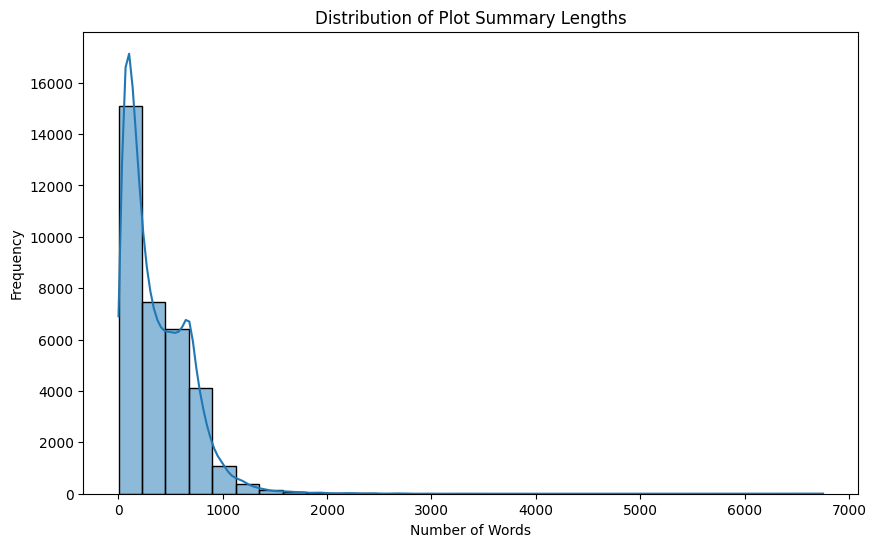

In [11]:
print("First few rows of the dataset:")
print(data.head())
print("Summary statistics of the dataset:")
print(data.describe())

# Unique values in each column
print("Unique values in 'Genre' column:", data['Genre'].nunique())
print("Unique genres:", data['Genre'].unique())

# Distribution of plot summary lengths
data['plot_length'] = data['Plot'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data['plot_length'], bins=30, kde=True)
plt.title('Distribution of Plot Summary Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

### The summary statistics of the dataset provide key insights into the 'Release Year' and 'plot_length' attributes. The dataset contains 34,886 entries for both attributes. The 'Release Year' ranges from 1901 to 2017, with a mean release year of 1981. The distribution shows that most movies were released around the 1980s to 2000s, as indicated by the 25th percentile (1957), median (1988), and 75th percentile (2007). The 'plot_length' attribute, representing the number of words in the plot summaries, has a mean of 372 words but exhibits significant variability (standard deviation of 316 words). Plot lengths range from very short summaries of just 2 words to extremely detailed summaries of up to 6,752 words. The median plot length is 284 words, with the interquartile range (122 to 581 words) indicating moderate plot lengths for most movies. 

### The provided histogram of plot summary lengths shows the distribution of the number of words in movie plot summaries. The distribution is right-skewed, indicating that most plot summaries are relatively short, with a high frequency of summaries around 100-500 words. The number of longer summaries (over 1000 words) decreases significantly, showing a long tail with few very detailed summaries reaching up to approximately 6750 words. This skewness suggests that while some movies have very detailed plots, the majority have concise descriptions. This variability in summary lengths will be an important factor to consider in the text preprocessing and model training phases of the project. 

# **3. Feature data types and plot**

Data types of the features:
Release Year         int64
Title               object
Origin/Ethnicity    object
Director            object
Cast                object
Genre               object
Wiki Page           object
Plot                object
plot_length          int64
dtype: object


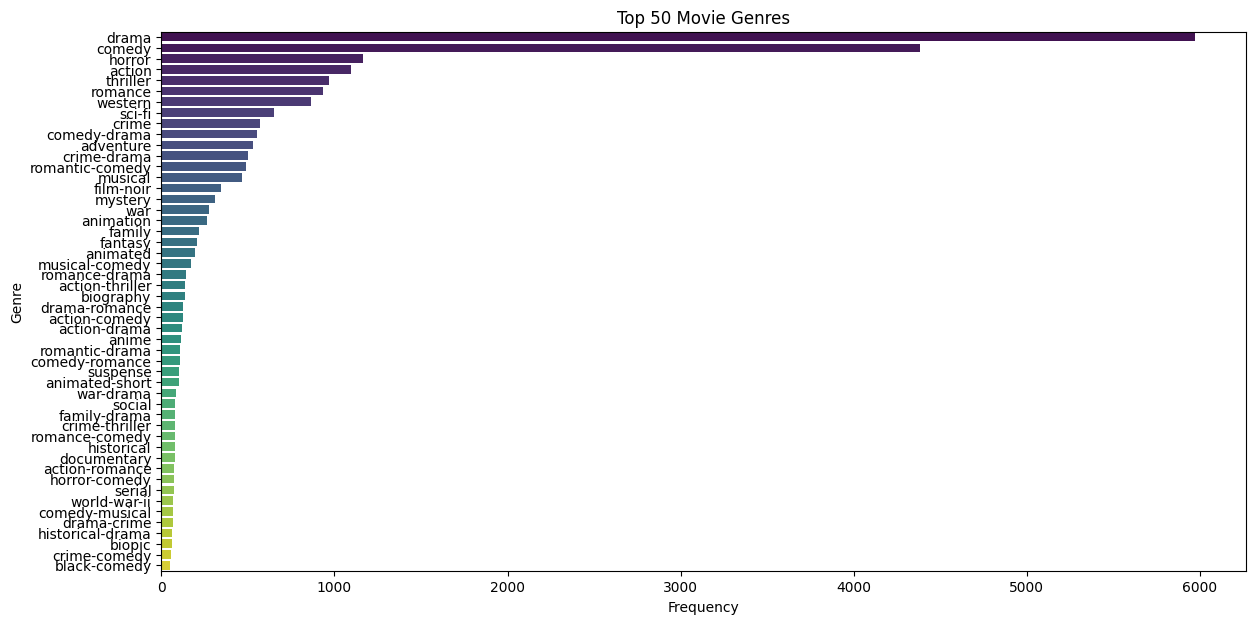

In [12]:
print("Data types of the features:")
print(data.dtypes)

# Plot the top 50 genres
plt.figure(figsize=(14, 7))
top_genres = data['Genre'].value_counts().nlargest(50)
sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
plt.title('Top 50 Movie Genres')
plt.xlabel('Frequency')
plt.ylabel('Genre')
plt.show()


### The bar plot displays the distribution of the top 20 most frequent movie genres in the dataset. The genre labeled as "unknown" is the most prevalent, indicating a significant number of entries where the genre is not specified. Among the known genres, "drama" is the most common, followed by "comedy." Other frequently occurring genres include "horror," "action," "thriller," "romance," and "western," demonstrating a wide range of popular genres in the dataset. Additionally, the plot highlights genres such as "crime," "adventure," "musical," "crime drama," "romantic comedy," "science fiction," "film noir," "mystery," "war," "animation," "comedy-drama," and "sci-fi," each with progressively lower frequencies. 

# Removing Unknown Genre and removing unwanted columns. 

In [13]:
data = data.sample(n=34886, random_state=42)  # Randomly sample 15,000 samples


In [14]:
# Define a function to count words
def word_count(text):
    return len(text.split())

In [15]:
# Apply the function to create a new column with word counts
data['word_count'] = data['Plot'].apply(word_count)

# Filter the dataset to keep rows where the word count is 100 or less
data = data[data['word_count'] <= 500]

# Drop the word_count column if it's no longer needed
data = data.drop(columns=['word_count'])

data

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,plot_length
24075,2012,Nobel Chor,Bengali,Suman Ghosh,"Mithun Chakraborty, Saswata Chatterjee, Sudipt...",NaN,https://en.wikipedia.org/wiki/Nobel_Chor,"The first Asian Nobel Laureate, Rabindranath T...",242
19057,1952,Trent's Last Case,British,Herbert Wilcox,"Michael Wilding, Margaret Lockwood, Orson Welles",detective,https://en.wikipedia.org/wiki/Trent%27s_Last_C...,A major international financier is found dead ...,121
24991,1977,Aafat,Bollywood,Atma Ram,"Navin Nischol, Leena Chandavarkar, Amjad Khan,...",NaN,https://en.wikipedia.org/wiki/Aafat,Inspector Amar and Inspector Chhaya are after ...,47
4480,1947,I Cover Big Town,American,William C. Thomas,"Hillary Brooke, Phillip Reed",drama,https://en.wikipedia.org/wiki/I_Cover_Big_Town,"""Illustrated Press"" society editor Lorelei Kil...",60
28035,2008,Sultan,Malayalam,Sreeprakash,"Vinu Mohan, Varada, Anoop Chandran, Sreejith Ravi",NaN,https://en.wikipedia.org/wiki/Sultan_(2008_film),Sivan (Vinu Mohan) is a medical college studen...,103
...,...,...,...,...,...,...,...,...,...
769,1929,Captain Lash,American,John G. Blystone,"Victor McLaglen, Claire Windsor",adventure,https://en.wikipedia.org/wiki/Captain_Lash,Lash is the head coal stoker on a steam ship w...,63
1685,1934,Forsaking All Others,American,W. S. Van Dyke,"Joan Crawford, Clark Gable, Robert Montgomery",romance,https://en.wikipedia.org/wiki/Forsaking_All_Ot...,Ever since Jeff Williams (Clark Gable) was a c...,459
21962,1997,Twilight of the Ice Nymphs,Canadian,Guy Maddin,"Pascale Bussières, Shelley Duvall, Frank Gorsh...",fantasy-drama,https://en.wikipedia.org/wiki/Twilight_of_the_...,"A newly released prisoner, Peter Glahn, return...",381
6265,1955,Creature with the Atom Brain,American,Edward L. Cahn,"Richard Denning, Angela Stevens",sci-fi,https://en.wikipedia.org/wiki/Creature_with_th...,A hulking zombie breaks into a mansion and kil...,278


In [16]:
data.shape

(23958, 9)

In [17]:
# Print the columns in the dataset
print("Columns in the dataset:", data.columns)

# Drop irrelevant columns
columns_to_drop = ['Release Year', 'Origin/Ethnicity', 'Director', 'Cast', 'Wiki Page']  # Specified columns to drop
data_cleaned = data.drop(columns=columns_to_drop, axis=1)

# Drop the rows with the "unknown" genre
data_cleaned = data_cleaned[data_cleaned['Genre'] != 'unknown']

# Print the shape of the cleaned dataset to confirm the changes
print("Shape of the dataset after dropping irrelevant columns and 'unknown' genre:", data_cleaned.shape)

# 2. Print the shape of the data
print("Shape of the dataset:", data_cleaned.shape)  # Display the number of rows and columns in the dataset

data_cleaned.head()


# Identify genres with fewer than two instances
genre_counts = data_cleaned['Genre'].value_counts()
genres_to_remove = genre_counts[genre_counts < 50]
print("Genres with fewer than 40 instances:")
print(genres_to_remove)

# Remove genres with fewer than 40 instances
genres_to_keep = genre_counts[genre_counts >= 50].index
data_cleaned = data_cleaned[data_cleaned['Genre'].isin(genres_to_keep)]



Columns in the dataset: Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot', 'plot_length'],
      dtype='object')
Shape of the dataset after dropping irrelevant columns and 'unknown' genre: (23958, 4)
Shape of the dataset: (23958, 4)
Genres with fewer than 40 instances:
Genre
comedy-short           49
anime                  47
biopic                 46
historical-drama       46
war-drama              43
                       ..
adventure-comedy        1
sci-fi-horror           1
family-musical          1
crime-drama-mystery     1
family-fantasy          1
Name: count, Length: 261, dtype: int64


In [18]:
data_cleaned.shape

(15847, 4)

## Reason to remove these columns and rows:
###  Machine learning models require accurate and relevant data for training. Rows with "unknown" genres do not provide any meaningful information about the target variable (genre) and can act as noise, potentially reducing the model's performance and accuracy. By removing these rows, you ensure that the model is trained only on data with well-defined genres, leading to better learning and generalization.


# Data Preprocessing


In [19]:
print(f"Shape of the dataset: {data_cleaned.shape}")

Shape of the dataset: (15847, 4)


## Initialize the set of English stopwords from the NLTK library.

In [20]:
stop_words = set(stopwords.words('english'))

## Initialize the WordNetLemmatizer from the NLTK library.

In [21]:
stop_words = set(stopwords.words('english'))  # Initialize the set of English stopwords from the NLTK library.
lemmatizer = WordNetLemmatizer()  # Initialize the WordNetLemmatizer from the NLTK library.


In [22]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense

In [23]:
def preprocess_text(text):
    # Step 1: Change text to lower case
    text_lower = text.lower()
    print("Lowercased Text:", text_lower)
    
    # Step 2: Tokenize the text
    words = word_tokenize(text_lower)
    print("Tokenized Words:", words)
    
    # Step 3: Remove stopwords and perform lemmatization
    words_filtered = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    print("Filtered and Lemmatized Words:", words_filtered)
    
    # Step 4: Join the processed words back into a single string
    final_text = ' '.join(words_filtered)
    print("Final Processed Text:", final_text)
    
    return final_text

## Apply preprocessing to a sample of the dataset for demonstration

In [24]:
sample_text = data_cleaned['Plot'].iloc[0]
preprocess_text(sample_text)

Lowercased Text: "illustrated press" society editor lorelei kilbourne (hillary brooke) is assigned to a police case. her crusading newspaper editor steve kilgore suspects that hard-luck suspect harry hilton (frank wilcox) has been framed on a murder rap. lorelei and steve proceed to help the police solve the crime, at the same time uncovering a conspiracy to bring a building firm to bankruptcy.
Tokenized Words: ['``', 'illustrated', 'press', "''", 'society', 'editor', 'lorelei', 'kilbourne', '(', 'hillary', 'brooke', ')', 'is', 'assigned', 'to', 'a', 'police', 'case', '.', 'her', 'crusading', 'newspaper', 'editor', 'steve', 'kilgore', 'suspects', 'that', 'hard-luck', 'suspect', 'harry', 'hilton', '(', 'frank', 'wilcox', ')', 'has', 'been', 'framed', 'on', 'a', 'murder', 'rap', '.', 'lorelei', 'and', 'steve', 'proceed', 'to', 'help', 'the', 'police', 'solve', 'the', 'crime', ',', 'at', 'the', 'same', 'time', 'uncovering', 'a', 'conspiracy', 'to', 'bring', 'a', 'building', 'firm', 'to', 

'illustrated press society editor lorelei kilbourne hillary brooke assigned police case crusading newspaper editor steve kilgore suspect suspect harry hilton frank wilcox framed murder rap lorelei steve proceed help police solve crime time uncovering conspiracy bring building firm bankruptcy'

In [25]:
import IPython

# Suppress output
with IPython.utils.io.capture_output() as captured:
    data_cleaned['cleaned_plot'] = data_cleaned['Plot'].apply(preprocess_text)

##  Apply preprocessing to the entire dataset 

In [26]:
data_cleaned.shape

(15847, 5)

In [27]:
import logging
import numpy as np
import torch
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

# Ensure the availability of a GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

# Tokenization and encoding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [28]:
data_cleaned

,Title,Genre,Plot,plot_length,cleaned_plot
4480,I Cover Big Town,drama,"""Illustrated Press"" society editor Lorelei Kil...",60,illustrated press society editor lorelei kilbo...
5342,Destination Meatball,animation,A line of people (including Woody) drool at th...,123,line people including woody drool window shop ...
16790,Devil's Knot,thriller,"In 1993, in the working class community of Wes...",120,1993 working class community west memphis arka...
9992,Mother Lode,adventure,When her husband George disappears after a fli...,204,husband george disappears flight northern brit...
18424,Gangway,musical,Newspaper film critic Pat Wayne (Jessie Matthe...,53,newspaper film critic pat wayne jessie matthew...
...,...,...,...,...,...
2433,Next Time I Marry,comedy,"In this screwy romantic comedy, a young woman ...",90,screwy romantic comedy young woman lucille bal...
769,Captain Lash,adventure,Lash is the head coal stoker on a steam ship w...,63,lash head coal stoker steam ship whose shipmat...
1685,Forsaking All Others,romance,Ever since Jeff Williams (Clark Gable) was a c...,459,ever since jeff williams clark gable child lov...
6265,Creature with the Atom Brain,sci-fi,A hulking zombie breaks into a mansion and kil...,278,hulking zombie break mansion kill gangster nam...


In [29]:
label = data_cleaned['Genre'].unique()

In [30]:
label

array(['drama', 'animation', 'thriller', 'adventure', 'musical', 'action',
       'action-romance', 'romantic-comedy', 'romance', 'comedy', 'horror',
       'animated-short', 'crime-drama', 'war', 'sci-fi', 'crime',
       'western', 'action-thriller', 'comedy-drama', 'social', 'mystery',
       'romance-drama', 'action-comedy', 'drama-romance',
       'musical-comedy', 'family-drama', 'biography', 'historical',
       'comedy-romance', 'animated', 'world-war-ii', 'fantasy',
       'film-noir', 'suspense', 'serial', 'documentary', 'family',
       'drama-crime', 'romantic-drama', 'comedy-musical', 'action-drama',
       'romance-comedy'], dtype=object)

In [31]:
len(label)

42

In [32]:
genre_map = {genre: i for i, genre in enumerate(data_cleaned['Genre'].unique())}
data_cleaned['Genre'] = data_cleaned['Genre'].factorize()[0].astype('int')

In [33]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(data_cleaned[['cleaned_plot']], data_cleaned['Genre'], test_size = 0.2, random_state = 42)

In [34]:
X_train1.shape

(12677, 1)

In [35]:
X_test1.shape

(3170, 1)

In [36]:
train_encodings = tokenizer(X_train1['cleaned_plot'].tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test1['cleaned_plot'].tolist(), truncation=True, padding=True, max_length=512)

train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']), 
    torch.tensor(train_encodings['attention_mask']), 
    torch.tensor(y_train1.values)
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']), 
    torch.tensor(test_encodings['attention_mask']), 
    torch.tensor(y_test1.values)
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [37]:
len(np.unique(data_cleaned['Genre']))

42

In [38]:
from tqdm import tqdm
# Define BERT model and move it to the specified device (GPU)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(np.unique(data_cleaned['Genre'])))
model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
total_steps = len(train_loader) * 4  # Number of training epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=total_steps)

# Setup logging
logging.basicConfig(level=logging.INFO)

# Training function
def train(model, train_loader, optimizer, scheduler, device, log_interval = 100):
    model.train()
    total_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
    for batch_idx, batch in progress_bar:
        batch = [item.to(device) for item in batch]
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        
        if batch_idx % log_interval == 0 and batch_idx > 0:
            avg_loss = total_loss / (batch_idx + 1)
            logging.info(f'Batch {batch_idx}/{len(train_loader)} - Loss: {avg_loss:.4f}')
            progress_bar.set_postfix(loss=avg_loss)
            
    avg_loss = total_loss / len(train_loader)
    logging.info(f'Average training loss: {avg_loss:.4f}')
    return avg_loss


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [39]:
# Training loop
logging.info("Starting training...")
for epoch in range(2):  # Number of epochs
    avg_loss = train(model, train_loader, optimizer, scheduler, device)
    logging.info(f'Epoch {epoch+1}/{2} - Loss: {avg_loss}')
logging.info("Training complete.")


Training: 100%|██████████| 1585/1585 [20:11<00:00,  1.31it/s, loss=1.72]


In [40]:
save_directory = "/kaggle/working"  # Specify the directory to save the model

# Save the model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print("Model saved successfully.")

Model saved successfully.


In [41]:
# Evaluation function
def evaluate(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = [item.to(device) for item in batch]
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch[2].cpu().numpy())
    unique_labels = sorted(set(all_labels))
    
    # Create a list of label names corresponding to the unique labels
    filtered_label_names = [label[i] for i in unique_labels]
    
    # Check if the lengths match
    if len(unique_labels) != len(filtered_label_names):
        raise ValueError("Mismatch between unique labels and filtered label names.")
    
    print(set(all_preds))
    accuracy = accuracy_score(all_labels, all_preds)
    print(accuracy)
    report = classification_report(all_labels, all_preds, labels = unique_labels, target_names=filtered_label_names)
    return accuracy, report


In [42]:
# Evaluate the model
logging.info("Starting evaluation...")
accuracy_bert, report_bert = evaluate(model, test_loader, device)
logging.info("Evaluation complete.")

print(f'BERT Accuracy: {accuracy_bert}')
print('BERT Classification Report:')
print(report_bert)


{0, 1, 2, 3, 4, 5, 8, 9, 10, 12, 13, 14, 15, 16, 20}
0.5069400630914827
BERT Accuracy: 0.5069400630914827
BERT Classification Report:
                 precision    recall  f1-score   support

          drama       0.51      0.75      0.60       894
      animation       0.39      0.59      0.47        27
       thriller       0.34      0.20      0.26       127
      adventure       0.45      0.59      0.51        74
        musical       0.37      0.47      0.41        70
         action       0.37      0.50      0.42       143
 action-romance       0.00      0.00      0.00        15
romantic-comedy       0.00      0.00      0.00        69
        romance       0.37      0.33      0.35       150
         comedy       0.59      0.64      0.61       600
         horror       0.58      0.72      0.64        96
 animated-short       0.00      0.00      0.00        15
    crime-drama       0.28      0.14      0.19        57
            war       0.44      0.83      0.57        47
         s

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
import numpy as np
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report
import logging
from tqdm import tqdm

# Define DistilBERT model and move it to the specified device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(np.unique(data_cleaned['Genre'])))
model.to(device)

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [44]:
# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
total_steps = len(train_loader) * 3  # Number of training epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=total_steps)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [45]:
# Setup logging
logging.basicConfig(level=logging.INFO)

In [46]:
# Training function
def train(model, train_loader, optimizer, scheduler, device, log_interval=100):
    model.train()
    total_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
    for batch_idx, batch in progress_bar:
        batch = [item.to(device) for item in batch]
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
        
        if batch_idx % log_interval == 0 and batch_idx > 0:
            avg_loss = total_loss / (batch_idx + 1)
            logging.info(f'Batch {batch_idx}/{len(train_loader)} - Loss: {avg_loss:.4f}')
            progress_bar.set_postfix(loss=avg_loss)
            
    avg_loss = total_loss / len(train_loader)
    logging.info(f'Average training loss: {avg_loss:.4f}')
    return avg_loss

In [47]:
# Training loop
logging.info("Starting training...")
for epoch in range(3):  # Number of epochs
    avg_loss = train(model, train_loader, optimizer, scheduler, device)
    logging.info(f'Epoch {epoch+1}/{3} - Loss: {avg_loss:.4f}')
logging.info("Training complete.")

save_directory = "/kaggle/working"  # Specify the directory to save the model

Training: 100%|██████████| 1585/1585 [10:10<00:00,  2.60it/s, loss=1.44]


In [48]:

# Save the model and tokenizer
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print("Model saved successfully.")

Model saved successfully.


In [49]:
# Evaluation function
def evaluate(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = [item.to(device) for item in batch]
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch[2].cpu().numpy())
    unique_labels = sorted(set(all_labels))
    
    # Create a list of label names corresponding to the unique labels
    filtered_label_names = [label[i] for i in unique_labels]
    
    # Check if the lengths match
    if len(unique_labels) != len(filtered_label_names):
        raise ValueError("Mismatch between unique labels and filtered label names.")
    
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, labels=unique_labels, target_names=filtered_label_names)
    return accuracy, report

In [50]:
# Evaluate the model
logging.info("Starting evaluation...")
accuracy_distilbert, report_distilbert = evaluate(model, test_loader, device)
logging.info("Evaluation complete.")

print(f'DistilBERT Accuracy: {accuracy_distilbert}')
print('DistilBERT Classification Report:')
print(report_distilbert)

DistilBERT Accuracy: 0.5028391167192429
DistilBERT Classification Report:
                 precision    recall  f1-score   support

          drama       0.52      0.71      0.60       894
      animation       0.44      0.70      0.54        27
       thriller       0.33      0.24      0.28       127
      adventure       0.41      0.54      0.47        74
        musical       0.34      0.34      0.34        70
         action       0.41      0.48      0.44       143
 action-romance       0.00      0.00      0.00        15
romantic-comedy       0.00      0.00      0.00        69
        romance       0.35      0.43      0.39       150
         comedy       0.55      0.66      0.60       600
         horror       0.58      0.71      0.64        96
 animated-short       0.00      0.00      0.00        15
    crime-drama       0.33      0.18      0.23        57
            war       0.49      0.68      0.57        47
         sci-fi       0.59      0.74      0.65        50
          cri

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
